In [1]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib as mlp

from matplotlib.animation import FuncAnimation
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

from models.fno import FNO3d
from models.lploss import LpLoss

In [3]:
from neuralop.datasets import load_darcy_flow_small

train_loader, test_loaders, output_encoder = load_darcy_flow_small(
        n_train=1000, batch_size=64,
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
)

ModuleNotFoundError: No module named 'neuraloperator'

In [2]:
data_path = '/project/data/l63-6.5T/'

In [3]:
# if torch.cuda.is_available(): 
#     dev = "cuda:0" 
# else: 
#     dev = "cpu"
dev = "cpu" 
device = torch.device(dev) 

In [4]:
# Data path
mesh_path = os.path.join(data_path, 'mesh.npy')
pdfn_path = os.path.join(data_path, 'prior.npy')

# Read numpy matrices
mesh = torch.from_numpy(np.load(mesh_path).reshape((1, 40, 40, 40, 3)))
pdfn = torch.from_numpy(np.load(pdfn_path).reshape((-1, 40, 40, 40, 1)))

In [5]:
pdf2d = pdfn.sum(dim=3).squeeze(-1)

# m, n = 3, 3
# ind = np.linspace(0, 198, m*n).astype(int).reshape((m, n))

# fig, ax = plt.subplots(m, n, figsize=(8, 10))

# for i in range(3):
#     for j in range(3):
#         ax[i, j].imshow(pdf2d[ind[i, j]])
#         ax[i, j].set_title(f'{ind[i, j]+1}')


In [6]:
pdfflat = pdf2d.view(pdf2d.shape[0], -1)
pdfmin = pdfflat.min(-1).values.reshape(-1, 1, 1).repeat((1, 40, 40))
pdfmax = pdfflat.max(-1).values.reshape(-1, 1, 1).repeat((1, 40, 40))
pdf2d = ((pdf2d - pdfmin)/(pdfmax - pdfmin))

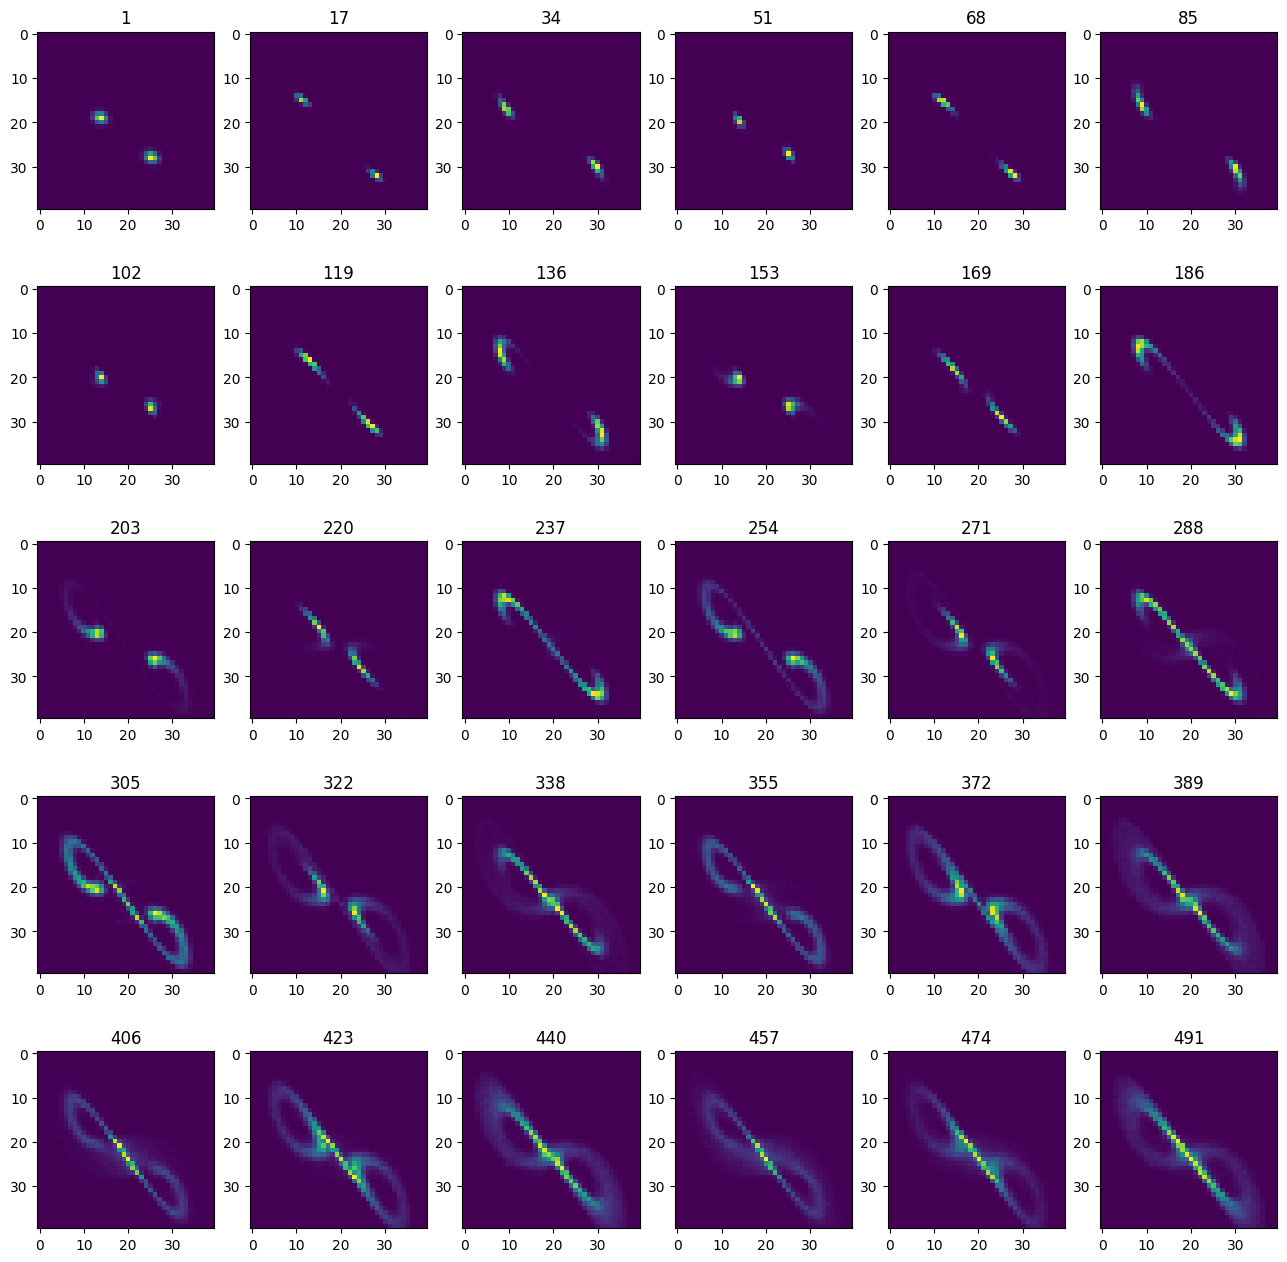

In [7]:
m, n = 5, 6
ind = np.linspace(0, 490, m*n).reshape(m, n).astype(int)

fig, ax = plt.subplots(m, n, figsize=(16,16))

for i in range(m):
    for j in range(n):
        ax[i, j].imshow(pdf2d[ind[i, j]])
        ax[i, j].set_title(f'{ind[i,j]+1}')

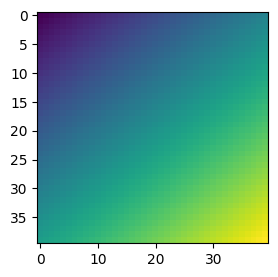

In [8]:
mesh2d = mesh.mean(-2)[...,:-1]
fig = plt.figure(figsize=(3, 3))
plt.imshow(mesh2d[0].sum(-1))

In [9]:
h = 1e-3
M = 40
Tf = 20
NT = int(Tf/h)
ts = torch.linspace(0, 20, int(NT/M)).reshape(-1, 1, 1, 1)
ts = ts.repeat(1, 40, 40, 1)

In [10]:
p = torch.concat([pdf2d.unsqueeze(-1), mesh2d.repeat(pdf2d.shape[0], 1, 1, 1)], dim=-1)
p = torch.concat([p, p[-1].unsqueeze(0)], dim=0)
# p = torch.concat([p, ts], dim=-1)
p.shape

torch.Size([542, 40, 40, 3])

In [11]:
def get_dataset(p, n_steps=10):
    xs = []
    ys = []
    for i in range(0, p.shape[0]-2*n_steps):
        xs.append(p[i: i+n_steps])
        ys.append(p[i+n_steps:i+2*n_steps, ..., 0].unsqueeze(-1))
    x = torch.stack(xs, dim=0)
    y = torch.stack(ys, dim=0)
    return TensorDataset(x, y)

In [12]:
full_ds = get_dataset(p, n_steps=10)
train_size = int(0.8 * len(full_ds))
test_size = len(full_ds) - train_size
train_ds, test_ds = torch.utils.data.random_split(full_ds, 
                                                  [train_size, test_size])


In [ ]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [ ]:
epochs = 500
e_start = 0
learning_rate = 0.01
scheduler_step = 4
scheduler_gamma = 0.85
learning_rate

0.01

In [ ]:
mode1 = 6
mode2 = 16
mode3 = 16
width = 64
n_blocks = 8

model = FNO3d(mode1, mode2, mode3, width, n_blocks=n_blocks, in_channel=3, device=device)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=scheduler_step, 
                                            gamma=scheduler_gamma)
l2loss = LpLoss(size_average=True, d=3, p=2)

In [ ]:
# dx1
grid_x1 = mesh2d[0, 0, :, 0]
grid_dx1 = grid_x1[1:-1] + grid_x1[:-2]/2 + grid_x1[2:]/2
grid_dx1 = grid_dx1[None, None, None, :, None].to(device)
print(grid_dx1.shape)

# dx2
grid_x2 = mesh2d[0, :, 0, 1]
grid_dx2 = grid_x2[1:-1] + grid_x2[:-2]/2 + grid_x2[2:]/2
grid_dx2 = grid_dx2[None, None, :, None, None].to(device)
print(grid_dx2.shape)

torch.Size([1, 1, 1, 38, 1])
torch.Size([1, 1, 38, 1, 1])


In [ ]:
for ep in range(1,epochs+1):
    model.train()
    train_l2 = 0
    test_l2 = 0
    counter = 0
    for x, y in train_dl:
        
        optimizer.zero_grad()

        # Move tensors to device
        x = x.to(device)
        y = y.to(device)
    
        # Prediction
        pred = model(x)

        # dy/dx1
        dy_dx1 = (y[:, :, :, 2:, :] - y[:, :, :, :-2, :])/grid_dx1
        dy_pred_dx1 = (pred[:, :, :, 2:, :] - pred[:, :, :, :-2, :])/grid_dx1

        # dy/dx2
        dy_dx2 = (y[:, :, 2:, :, :] - y[:, :, :-2, :, :])/grid_dx2
        dy_pred_dx2 = (pred[:, :, 2:, :, :] - pred[:, :, :-2, :, :])/grid_dx2

        # Compute loss
        loss = l2loss(pred, y) + l2loss(dy_pred_dx1, dy_dx1) + l2loss(dy_pred_dx2, dy_dx2)
        
        loss.backward()
        optimizer.step()

        train_l2 += loss.item()

        counter += 1
        if counter % 5 == 0:
            print(f'epoch: {ep}, batch: {counter}/{len(train_dl)}, train loss: {loss.item():.4f}')
    
    scheduler.step()
    
    if ep % 2 == 0:
        
        model.eval()
        
        for x, y in test_dl:

            x = x.to(device)
            y = y.to(device)
        
            pred = model(x)
            ori_loss = 0

            num_examples = x.shape[0]
            ori_loss = l2loss(pred, y)
            
            loss = ori_loss

            test_l2 += loss.item()
        
        print(f'epoch: {ep}, train loss: {train_l2/len(train_dl):.4f}, test loss: {test_l2/len(test_dl):.4f}')
    
    else:
        print(f'epoch: {ep}, train loss: {train_l2/len(train_dl):.4f}')
    
    # lr_ = optimizer.param_groups[0]['lr']
    # if ep % 2 == 0:z
    #     PATH = f'saved_models/dP_UFNO_{ep}ep_{width}width_{mode1}m1_{mode2}m2_{train_a.shape[0]}train_{lr_:.2e}lr'

    #     torch.save(model, PATH)

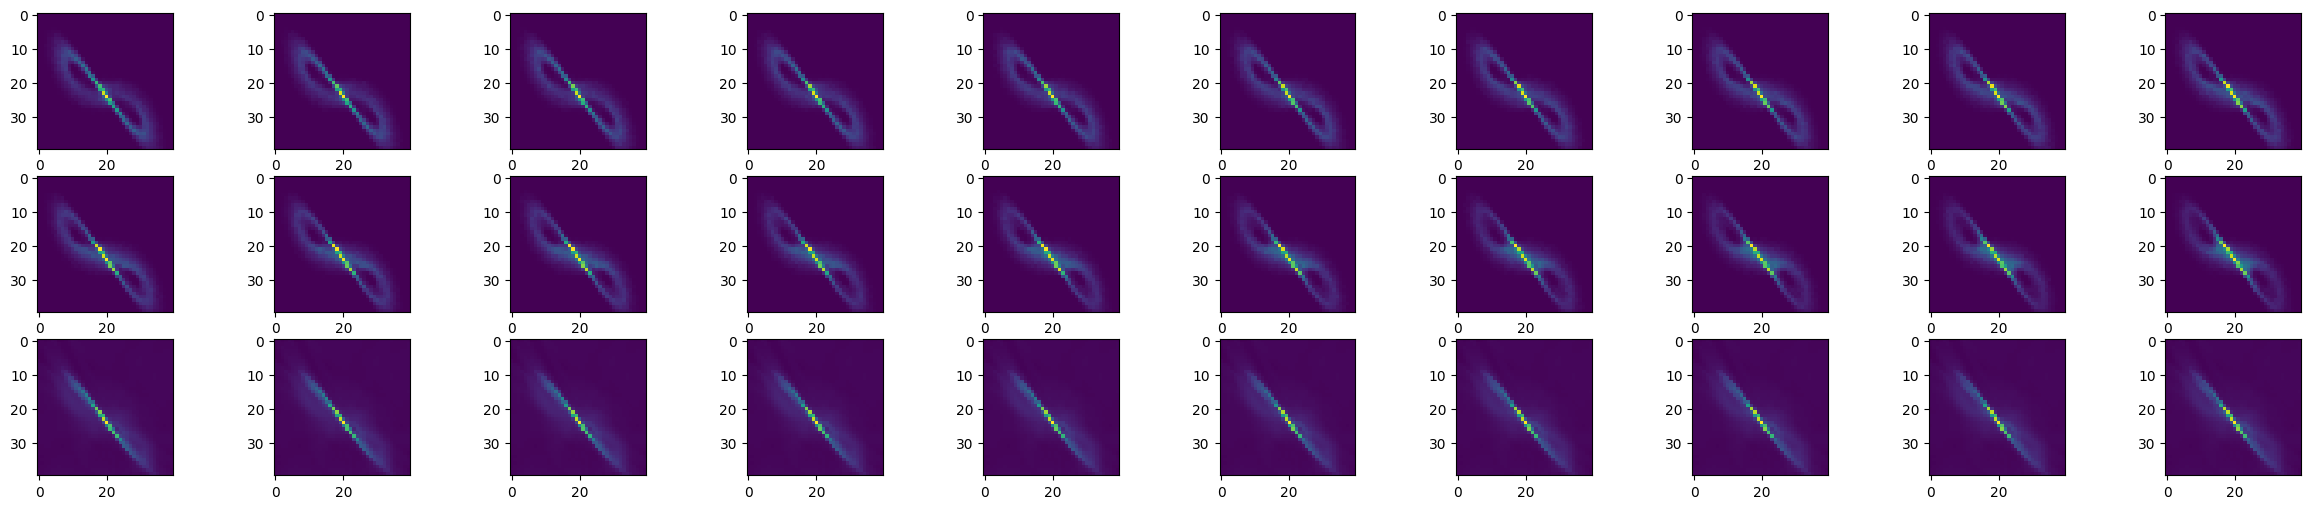

In [ ]:
ind = 0
a, p = full_ds[-20]

fig, ax = plt.subplots(3, a.shape[0], figsize=(a.shape[0]*3,6))


for j in range(a.shape[0]):
    ax[0, j].imshow(a[j, ..., 0])


for j in range(a.shape[0]):
    ax[1, j].imshow(p[j, ..., 0])

pred = model(a.unsqueeze(0).to(device))[0].cpu().detach().numpy()

for j in range(a.shape[0]):
    ax[2, j].imshow(pred[j, ..., 0])
